In [1]:
############
# Imports #
############

import json
import os

import torch
import wandb
from torch.utils.data import DataLoader

from model.cnn_classifier import model_4D
from model.finetune import FinetuneLoop
from model.pseudomask import Pseudomasks
from model.train import ClassifierTrainLoop
from utils.data_modules import ImageDataset, TestSet, filter_dataset

from utils.data_modules import SaveFeatures
from torch.autograd import Variable
import matplotlib.pyplot as plt

import numpy as np
import torch
from sklearn.mixture import GaussianMixture
from scipy import ndimage
from torchmetrics.classification import MulticlassJaccardIndex

# Function to create larger clusters
def create_larger_clusters(seg_mask, min_size=100):
    # Apply morphological closing to connect nearby regions
    struct = ndimage.generate_binary_structure(2, 2)
    closed = ndimage.binary_closing(seg_mask, structure=struct, iterations=2)
    
    # Label connected components
    labeled, num_features = ndimage.label(closed)
    
    # Remove small clusters
    sizes = ndimage.sum(closed, labeled, range(num_features + 1))
    mask_sizes = sizes < min_size
    remove_pixel = mask_sizes[labeled]
    labeled[remove_pixel] = 0
    
    # Relabel remaining clusters
    labels_id = np.unique(labeled)
    labels_id = labels_id[labels_id != 0]
    new_labeled = np.zeros_like(labeled)
    for i, label in enumerate(labels_id):
        new_labeled[labeled == label] = i + 1
    
    return new_labeled

artifact_path = 'nadjaflechner/VGG_CAMs/classification_model:v45'

api = wandb.Api()
artifact = api.artifact(artifact_path)
artifact_dir = artifact.download()

state_dict = torch.load(f"{artifact_dir}/model.pth", map_location=torch.device('cpu'))
model = model_4D()
model.load_state_dict(state_dict)
model.eval()

testset_dir = '/Users/nadja/Documents/UU/Thesis/Data/Verified_GTs'
depth_layer = 'hs'
normalize = True
finetune = False

test_set = TestSet(depth_layer, testset_dir, normalize)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=1)

/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <2C8BF30B-D1BA-315D-BF33-9DF6F3757AB3> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
wandb:   1 of 1 files downloaded.  


### Calculate baseline jaccard performance:

In [ ]:
counter = 0
jaccard = MulticlassJaccardIndex(num_classes=2, average=None)

running_jaccard = []

# im, lab, perc, gt_mask = next(iter(test_loader))
for im, lab, perc, gt_mask in test_loader:
    if sum(gt_mask.flatten()) > 0:
        image = im[:, 3, :, :] # Replace this with your actual image tensor

        # Reshape the image to be 2D: (pixels, features)
        image_2d = image.view(-1, 1)  # Reshape to [160000, 1]

        # Fit GMM
        gmm = GaussianMixture(n_components=2, random_state=42)
        gmm.fit(image_2d)

        # Predict clusters
        labels = gmm.predict(image_2d)

        # Reshape labels back to image shape
        segmentation = labels.reshape(400, 400)

        # Create larger clusters for each class
        larger_clusters = np.zeros_like(segmentation)
        for class_id in range(2):  # Assuming 2 classes (0 and 1)
            class_mask = (segmentation == class_id).astype(int)
            larger_class_clusters = create_larger_clusters(class_mask)
            larger_clusters[larger_class_clusters > 0] = class_id

        running_jaccard.append(jaccard(torch.Tensor(larger_clusters), gt_mask.squeeze())[1].detach())

print(f"average jaccard = {sum(running_jaccard)/len(running_jaccard)}")


### Visualize the GMM from specific images: 

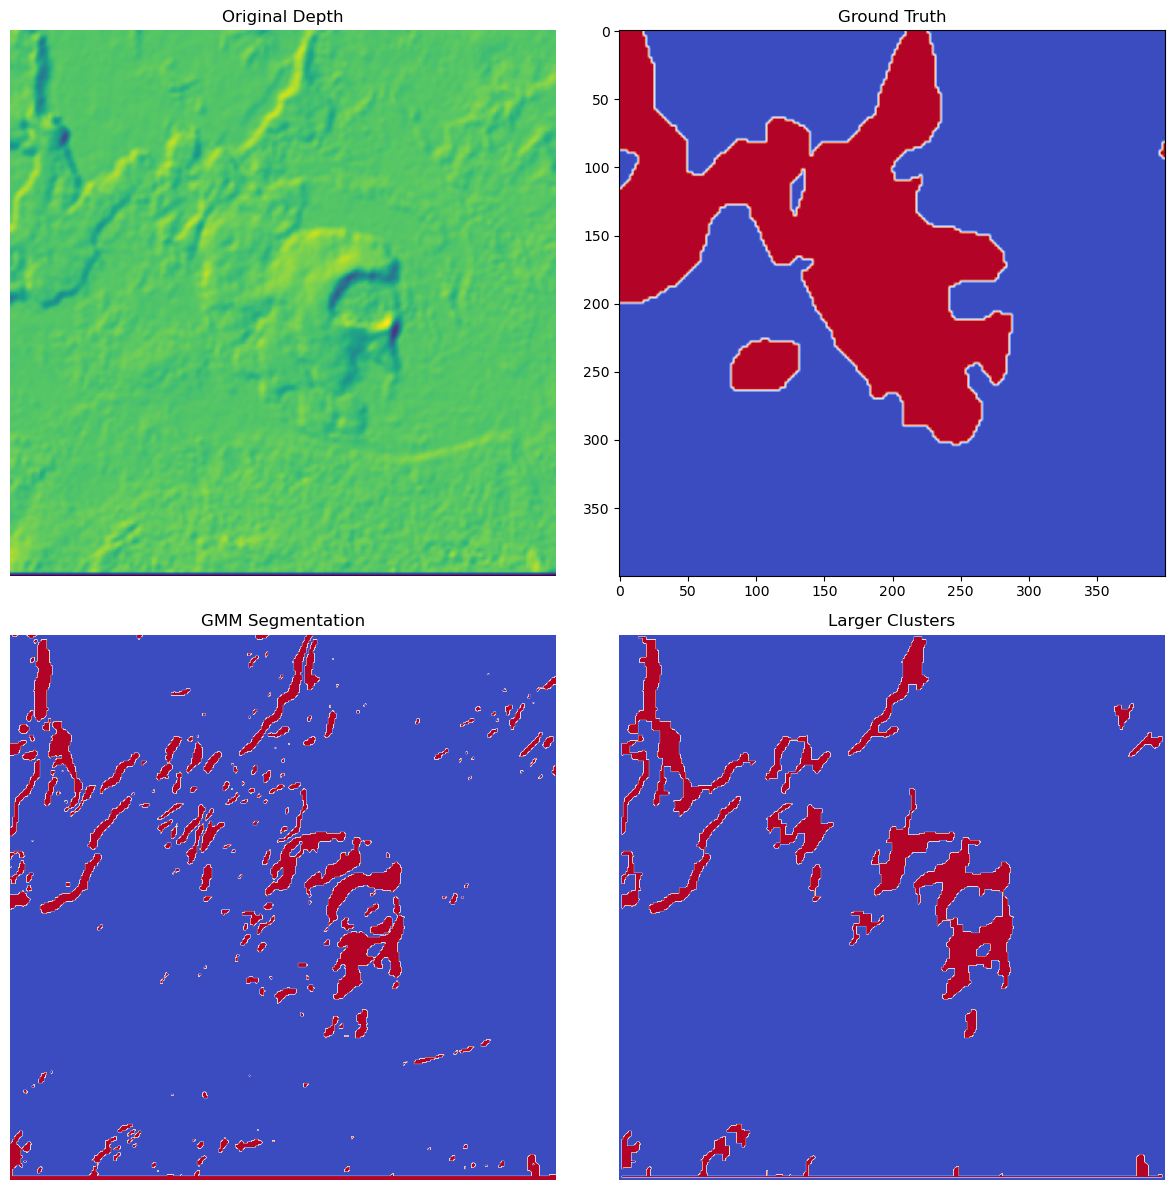

In [64]:
import torch
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Assuming your image tensor is named 'image' and has shape [1, 4, 400, 400]
# If it's not already, ensure it's on CPU and converted to numpy
image = im[:, 3, :, :] # Replace this with your actual image tensor

# Reshape the image to be 2D: (pixels, features)
image_2d = image.view(-1, 1)  # Reshape to [160000, 1]

# Fit GMM
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(image_2d)

# Predict clusters
labels = gmm.predict(image_2d)

# Reshape labels back to image shape
segmentation = labels.reshape(400, 400)

# Create larger clusters for each class
larger_clusters = np.zeros_like(segmentation)
for class_id in range(2):  # Assuming 2 classes (0 and 1)
    class_mask = (segmentation == class_id).astype(int)
    larger_class_clusters = create_larger_clusters(class_mask)
    larger_clusters[larger_class_clusters > 0] = class_id

# Plot original image (using first 3 channels as RGB) and segmentation result
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

# Plot original image
ax1.imshow(im[:,3,:,:].squeeze().cpu().detach().long().numpy())  # Assuming first 3 channels are RGB
ax1.set_title('Original Depth')
ax1.axis('off')

ax2.imshow(gt_mask.squeeze(), cmap='coolwarm')
ax2.set_title('Ground Truth')
ax2.axis('off')

# Plot segmentation result
ax3.imshow(segmentation, cmap='coolwarm')
ax3.set_title('GMM Segmentation')
ax3.axis('off')

ax4.imshow(larger_clusters, cmap='coolwarm')
ax4.set_title('Larger Clusters')
ax4.axis('off')

plt.tight_layout()
plt.show()

### Baseline of all + or all - predictions:

In [8]:
import pandas as pd 
import rasterio
import numpy as np
from torchmetrics.functional import jaccard_index
from torchmetrics.functional.classification import multiclass_accuracy
import torch

file = "/Users/nadja/Documents/1. Project/Thesis/Permafrost-Segmentation/Verified_GT/new_palsa_labels.csv"
labels = pd.read_csv(file, header = 0, names = ['image', 'palsa_percentage', 'matthias', 'difference'])

labels_d = labels.loc[labels['palsa_percentage']>0]
labels_df = labels_d.loc[labels_d['difference']<10]

zero_bg_jaccard = []
zero_target_jaccard = []
zero_overall_accuracy = []
zero_target_accuracy = []
zero_bg_accuracy = []

ones_bg_jaccard = []
ones_target_jaccard = []
ones_overall_accuracy = []
ones_target_accuracy = []
ones_bg_accuracy = []

num = 0
for i in labels_df['image']:
    img_path = f"/Users/nadja/Documents/1. Project/Thesis/Permafrost-Segmentation/Verified_GT/groundtruth_mask/{i}.tif"
    with rasterio.open(img_path) as src:
        mask = src.read(1)
        mask = mask.flatten()
        zero_pred = np.zeros_like(mask)
        ones_pred = np.ones_like(mask)

        # Calculate Jaccard score (IoU) for both classes
        jaccard = jaccard_index(
            torch.Tensor(zero_pred).long(), 
            torch.Tensor(mask).long(), 
            task="multiclass", 
            num_classes=2, 
            average='none'
        )
        zero_bg_jaccard.append(jaccard[0])
        zero_target_jaccard.append(jaccard[1])

        jaccard = jaccard_index(
            torch.Tensor(ones_pred).long(), 
            torch.Tensor(mask).long(), 
            task="multiclass", 
            num_classes=2, 
            average='none'
        )
        ones_bg_jaccard.append(jaccard[0])
        ones_target_jaccard.append(jaccard[1])

        # Overall accuracy
        accuracy = multiclass_accuracy(
            torch.Tensor(zero_pred).long(), 
            torch.Tensor(mask).long(), 
            num_classes=2, 
            average='micro'
        )
        zero_overall_accuracy.append(accuracy)

        # Overall accuracy
        no_avg_accuracy = multiclass_accuracy(
            torch.Tensor(zero_pred).long(), 
            torch.Tensor(mask).long(), 
            num_classes=2, 
            average='none'
        )
        zero_bg_accuracy.append(no_avg_accuracy[0])
        zero_target_accuracy.append(no_avg_accuracy[1])

        # Overall accuracy
        accuracy = multiclass_accuracy(
            torch.Tensor(ones_pred).long(), 
            torch.Tensor(mask).long(), 
            num_classes=2, 
            average='micro'
        )
        ones_overall_accuracy.append(accuracy)

        # Overall accuracy
        no_avg_accuracy = multiclass_accuracy(
            torch.Tensor(ones_pred).long(), 
            torch.Tensor(mask).long(), 
            num_classes=2, 
            average='none'
        )
        ones_bg_accuracy.append(no_avg_accuracy[0])
        ones_target_accuracy.append(no_avg_accuracy[1])

    print(num)
    num += 1
    
avg_zero_bg_jaccard = sum(zero_bg_jaccard)/len(zero_bg_jaccard)
avg_zero_target_jaccard = sum(zero_target_jaccard)/len(zero_target_jaccard)
avg_zero_overall_accuracy = sum(zero_overall_accuracy)/len(zero_overall_accuracy)
avg_zero_target_accuracy = sum(zero_target_accuracy)/len(zero_target_accuracy)
avg_zero_bg_accuracy = sum(zero_bg_accuracy)/len(zero_bg_accuracy)

avg_ones_bg_jaccard = sum(ones_bg_jaccard)/len(ones_bg_jaccard)
avg_ones_target_jaccard = sum(ones_target_jaccard)/len(ones_target_jaccard)
avg_ones_overall_accuracy = sum(ones_overall_accuracy)/len(ones_overall_accuracy)
avg_ones_target_accuracy = sum(ones_target_accuracy)/len(ones_target_accuracy)
avg_ones_bg_accuracy = sum(ones_bg_accuracy)/len(ones_bg_accuracy)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106


In [9]:
print(f"avg_zero_bg_jaccard = {avg_zero_bg_jaccard}")
print(f"avg_zero_target_jaccard = {avg_zero_target_jaccard}")
print(f"avg_zero_overall_accuracy = {avg_zero_overall_accuracy}")
print(f"avg_zero_target_accuracy = {avg_zero_target_accuracy}")
print(f"avg_zero_bg_accuracy = {avg_zero_bg_accuracy}")

print(f"avg_ones_bg_jaccard = {avg_ones_bg_jaccard}")   
print(f"avg_ones_target_jaccard = {avg_ones_target_jaccard}")
print(f"avg_ones_overall_accuracy = {avg_ones_overall_accuracy}")
print(f"avg_ones_target_accuracy = {avg_ones_target_accuracy}")
print(f"avg_ones_bg_accuracy = {avg_ones_bg_accuracy}")

avg_zero_bg_jaccard = 0.8978737592697144
avg_zero_target_jaccard = 0.0
avg_zero_overall_accuracy = 0.8978737592697144
avg_zero_target_accuracy = 0.0
avg_zero_bg_accuracy = 1.0
avg_ones_bg_jaccard = 0.0
avg_ones_target_jaccard = 0.10212638974189758
avg_ones_overall_accuracy = 0.10212638974189758
avg_ones_target_accuracy = 1.0
avg_ones_bg_accuracy = 0.0


In [12]:
import pandas as pd 
import rasterio
import numpy as np
from torchmetrics.functional import jaccard_index
from torchmetrics.functional.classification import multiclass_accuracy
import torch

file = "/Users/nadja/Documents/1. Project/Thesis/Permafrost-Segmentation/Verified_GT/new_palsa_labels.csv"
labels = pd.read_csv(file, header = 0, names = ['image', 'palsa_percentage', 'matthias', 'difference'])

labels_d = labels.loc[labels['palsa_percentage']>0]
labels_df = labels_d.loc[labels_d['difference']<10]

random_bg_jaccard = []
random_target_jaccard = []
random_overall_accuracy = []
random_target_accuracy = []
random_bg_accuracy = []

num = 0
for i in labels_df['image']:
    img_path = f"/Users/nadja/Documents/1. Project/Thesis/Permafrost-Segmentation/Verified_GT/groundtruth_mask/{i}.tif"
    with rasterio.open(img_path) as src:
        mask = src.read(1)
        mask = mask.flatten()
        random_pred = np.random.choice([0, 1], size=mask.shape, p=[0.5, 0.5])

        jaccard = jaccard_index(
            torch.Tensor(random_pred).long(), 
            torch.Tensor(mask).long(), 
            task="multiclass", 
            num_classes=2, 
            average='none'
        )
        random_bg_jaccard.append(jaccard[0])
        random_target_jaccard.append(jaccard[1])

        # Overall accuracy
        accuracy = multiclass_accuracy(
            torch.Tensor(random_pred).long(), 
            torch.Tensor(mask).long(), 
            num_classes=2, 
            average='micro'
        )
        random_overall_accuracy.append(accuracy)        

        no_avg_accuracy = multiclass_accuracy(
            torch.Tensor(random_pred).long(), 
            torch.Tensor(mask).long(), 
            num_classes=2, 
            average='none'
        )
        random_bg_accuracy.append(no_avg_accuracy[0])
        random_target_accuracy.append(no_avg_accuracy[1])

    print(num)
    num += 1
    
avg_random_bg_jaccard = sum(random_bg_jaccard)/len(random_bg_jaccard)
avg_random_target_jaccard = sum(random_target_jaccard)/len(random_target_jaccard)
avg_random_overall_accuracy = sum(random_overall_accuracy)/len(random_overall_accuracy)
avg_random_target_accuracy = sum(random_target_accuracy)/len(random_target_accuracy)
avg_random_bg_accuracy = sum(random_bg_accuracy)/len(random_bg_accuracy)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106


In [13]:
print(f"avg_random_bg_jaccard = {avg_random_bg_jaccard}")
print(f"avg_random_target_jaccard = {avg_random_target_jaccard}")
print(f"avg_random_overall_accuracy = {avg_random_overall_accuracy}")
print(f"avg_random_target_accuracy = {avg_random_target_accuracy}")
print(f"avg_random_bg_accuracy = {avg_random_bg_accuracy}")



avg_random_bg_jaccard = 0.4698789715766907
avg_random_target_jaccard = 0.0820150077342987
avg_random_overall_accuracy = 0.4999685287475586
avg_random_target_accuracy = 0.5024080276489258
avg_random_bg_accuracy = 0.4999789297580719
